In [1]:
# General Imports and helper functions

import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

def visualize_results(results):
    plt.plot(results["cost_history"], lw=2)
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.show()


def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = (
            estimator.run(ansatz, hamiltonian, parameter_values=current_vector)
            .result()
            .values[0]
        )
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(
                callback_dict["iters"], current_cost
            ),
            end="\r",
            flush=True,
        )

    return callback


service = QiskitRuntimeService()
backend = service.get_backend("ibmq_kolkata")

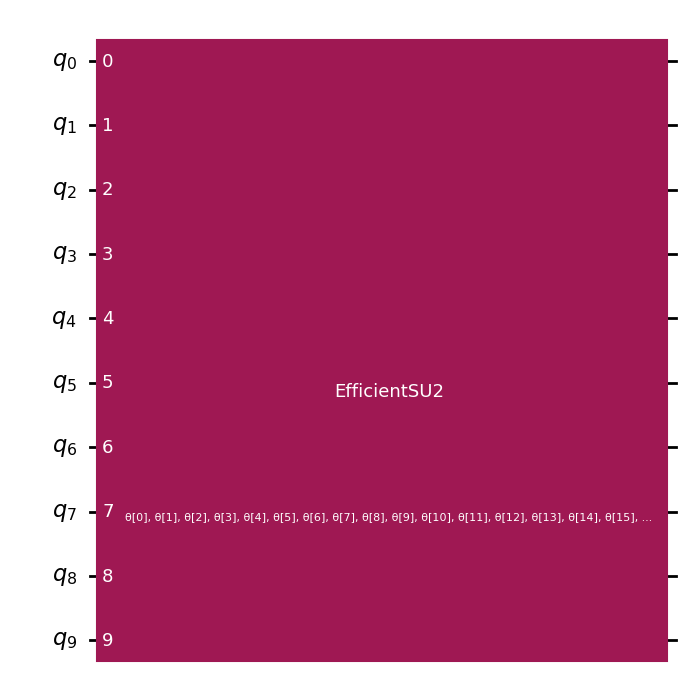

In [2]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService

num_spins = 10
ansatz = EfficientSU2(num_qubits=num_spins, reps=3)

# Remember to insert your token in the QiskitRuntimeService constructor 
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, min_num_qubits=num_spins, simulator=False)

coupling = backend.target.build_coupling_map()
reduced_coupling = coupling.reduce(list(range(num_spins)))

edgelist = reduced_coupling.graph.edge_list()
hamlist = []

for edge in edgelist:
    hamlist.append(("ZZ", edge, 0.5))
    hamlist.append(("YY", edge, 0.5))
    hamlist.append(("XX", edge, 0.5))

for qubit in reduced_coupling.physical_qubits:
    hamlist.append(("Z", [qubit], np.random.random() * 2 - 1))

hamiltonian = SparsePauliOp.from_sparse_list(hamlist, num_qubits=num_spins)

ansatz.draw("mpl", style="iqp")

/Users/pcchen/miniforge3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/pcchen/miniforge3/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


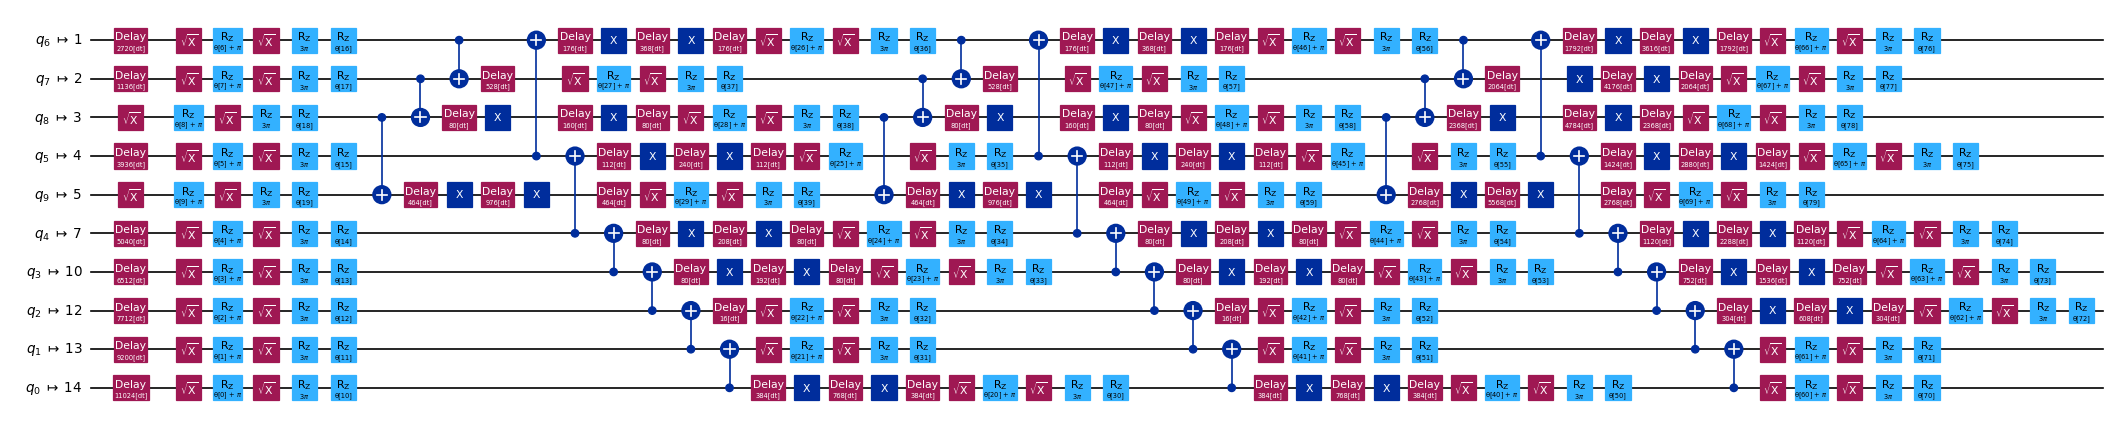

In [3]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate

target = backend.target
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations=target.durations()),
        PadDynamicalDecoupling(
            durations=target.durations(),
            dd_sequences=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)
ansatz_ibm = pm.run(ansatz)
observable_ibm = hamiltonian.apply_layout(ansatz_ibm.layout)
ansatz_ibm.draw("mpl", scale=0.6, style="iqp", fold=-1, idle_wires=False)